In [2]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [3]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 2
    nelecas = mf.nelec
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

for fname in ['scf.hdf5','ci.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)    
            
scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_h2(scf_checkfile)
# mcc = run_casci(scf_checkfile, ci_checkfile)

converged SCF energy = -0.856973623578646  <S^2> = 2  2S+1 = 3


In [3]:
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools
from accumulators import ABQMCEnergyAccumulator

# def initialize_boson_qmc_objects(
#     dft_checkfile,
# ):  
#     mol, mf, mc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = 'ci.hdf5')
#     wf, to_opt = wftools.generate_boson_wf(
#         mol, mf, jastrow = None
#     )
#     return wf

# def initialize_qmc_objects(
#     dft_checkfile: str,
# ):
#     mol, mf, mc = pyscftools.recover_pyscf(dft_checkfile, ci_checkfile = 'ci.hdf5')
#     wf, to_opt = wftools.generate_wf(
#         mol, mf, jastrow=None
#     )
#     return wf

In [4]:
# trials = 1
# for i in range(trials):
#     nconfig = 123
#     mol, mf, mcc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = 'ci.hdf5')
#     target_root = 0
#     if not hasattr(mcc.ci, "shape") or len(mcc.ci.shape) == 3:
#             mcc.ci = mcc.ci[target_root]
#     wf, to_opt = wftools.generate_boson_wf(
#             mol, mf, mc=mcc, jastrow = None, jastrow_kws=None, slater_kws=None
#         )

#     configs = mc.fixed_initial_guess(mol, nconfig)
#     configs = mc.initial_guess(mol, nconfig, seed = 100)
    
#     e=0
#     sign, val, _ = wf.recompute(configs)
#     # import pdb
#     # pdb.set_trace()
#     g1, val2, _ = wf.gradient_value(e, configs.electron(e))
#     # plt.scatter(np.exp(val), valb)
# # x = np.linspace(0, 0.7, 100)
# # plt.plot(x,x)
# # plt.xlabel('Grad bosonic no jastrow')
# # plt.ylabel('Grad fermionic no jastrow')
# # plt.title(str(trials) + ' configurations')

In [5]:
def limdrift(g, cutoff=1):
    """
    Limit a vector to have a maximum magnitude of cutoff while maintaining direction

    :parameter g: a [nconf,ndim] vector
    :parameter cutoff: the maximum magnitude
    :returns: The vector with the cutoff applied.
    """
    tot = np.linalg.norm(g, axis=1)
    mask = tot > cutoff
    g[mask, :] = cutoff * g[mask, :] / tot[mask, np.newaxis]
    return g

In [15]:
# Multi determinant boson new gradient
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools

nconfig = 323
multi = False
if multi:
    mol, mf, mcc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = 'ci.hdf5')
    target_root = 0
    if not hasattr(mcc.ci, "shape") or len(mcc.ci.shape) == 3:
        mcc.ci = mcc.ci[target_root]
else:
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    mcc = None
    
wf, to_opt = wftools.generate_boson_wf(
        mol, mf, mc=mcc, jastrow = None, jastrow_kws=None, slater_kws=None
        )
wf    


Number of determinants in the bosonic wavefunction= 1


Text(0.5, 1.0, 'HF boson new gradient, e2 at [-0.1  0.9 -1.5]')

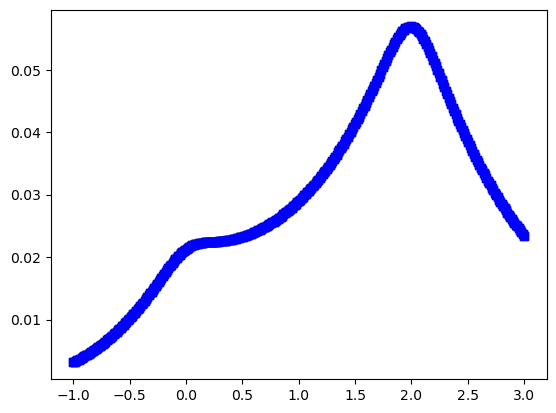

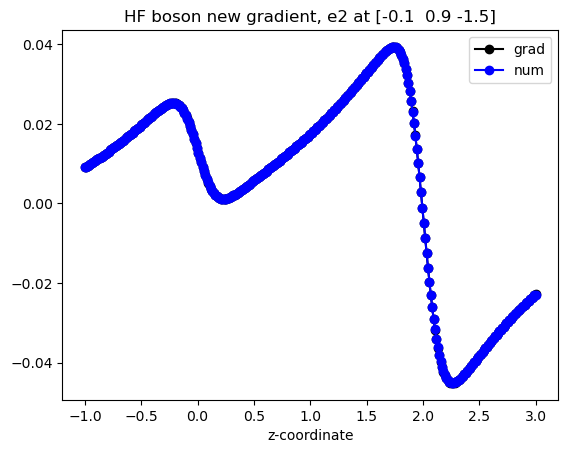

In [16]:
configs = mc.fixed_initial_guess(mol, nconfig)
e=0
sign, val = wf.recompute(configs)
g1, saved = wf.gradient_value(e, configs.electron(e))

val2 = saved['psi']
_, psi1 = wf.value()

y1 = np.gradient(val2)
y2 = g1
dx = configs.configs[1]-configs.configs[0]
dx = dx[dx!=0][0]
# print(dx)

x = configs.configs[:,0][:,2]
h1 = (0,0, 0.0)
h2 = (2.0, 0.0)
e2pos = np.array2string(configs.configs[:,1][0])




plt.figure()
plt.plot(x,val, '-sk', label='recompute')
plt.plot(x,val2, '-sb', label='from_grad')
# plt.plot(x,psi1, '-sr', label='from_val')
# plt.legend()
# plt.xlabel('z-coordinate')
# plt.title('Multi determinant boson new gradient, e2 at {}'.format(e2pos) )

plt.figure()
plt.plot(x,g1[2], '-ok', label='grad')
plt.plot(x,y1/dx, '-ob', label='num')
plt.xlabel('z-coordinate')
plt.legend()
plt.title('HF boson new gradient, e2 at {}'.format(e2pos))




In [105]:
tstep = 0.3
nconf = psi1.shape[0]
lng1 = g1/np.tile(psi1, (3,1))
grad = - limdrift(np.real(lng1.T))
rng = np.random #.RandomState(i)
gauss = rng.normal(scale=np.sqrt(tstep), size=(nconf, 3))*0.0 + 1.0

newcoorde = configs.configs[:, e, :] + gauss #+ grad * tstep
newcoorde = configs.make_irreducible(e, newcoorde)

In [106]:
g2, new_val, saved = wf.gradient_value(e, newcoorde, configs=configs) 
cf = configs.copy()
cf.configs[:,e,:] = newcoorde.configs
sign2, val2, vald2 = wf.value_updated(cf) 
psi2 = saved['psi']  
lng2 = g2/np.tile(psi2, (3,1))
new_grad = -limdrift(np.real(lng2.T))
forward = np.sum(gauss**2, axis=1)
backward = np.sum((gauss + tstep * (grad + new_grad)) ** 2, axis=1)

t_prob = np.exp(1 / (2 * tstep) * (forward - backward))
ratio = np.abs(new_val) ** 2 * t_prob

accept = ratio > np.random.rand(nconf)

In [110]:
y1 = np.gradient(psi2)
y2 = g2
dx = newcoorde.configs[1]-newcoorde.configs[0]
dx = dx[dx!=0][0]
print(dx)

x = newcoorde.configs[:,2]
h1 = (0,0, 0.0)
h2 = (2.0, 0.0)
e2pos = 'unk'
plt.figure()
# plt.plot(x,val, '-sk', label='value')
# plt.plot(x,psi2, '-sb', label='from_grad')
# val
# plt.legend()
# plt.xlabel('z-coordinate')
# plt.title('Multi determinant boson new gradient, e2 at {}'.format(e2pos) )

# plt.figure()
# plt.plot(x,g2[2], '-ok', label='grad')
# plt.plot(x,y1/dx, '-ob', label='num')
# plt.xlabel('z-coordinate')
# plt.legend()
# plt.title('Multi determinant boson new gradient, e2 at {}'.format(e2pos))




0.012422360248447228


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [111]:
newcoorde.configs.shape

(323, 3)

In [109]:
newcoorde.configs[1]

array([0.9       , 0.9       , 0.01242236])

> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(320)generate_boson_wf()
    318     import pdb
    319     pdb.set_trace()
--> 320     if jastrow == None:
    321         wf, to_opt1 = generate_boson(mol, mf, mc=mc, **slater_kws)
    322         to_opt = {"wf1" + k: v for k, v in to_opt1.items()}



ipdb>  c


Number of determinants in the bosonic wavefunction= 1
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/bosonwf.py(140)recompute()
    138         import pdb
    139         pdb.set_trace()
--> 140         nconf, nelec, ndim = configs.configs.shape
    141         aos = self.orbitals.aos("GTOval_sph", configs)
    142         self._aovals = aos.reshape(-1, nconf, nelec, aos.shape[-1])



ipdb>  c


0.032786885245901676


Text(0.5, 1.0, 'Single determinant boson new gradient')

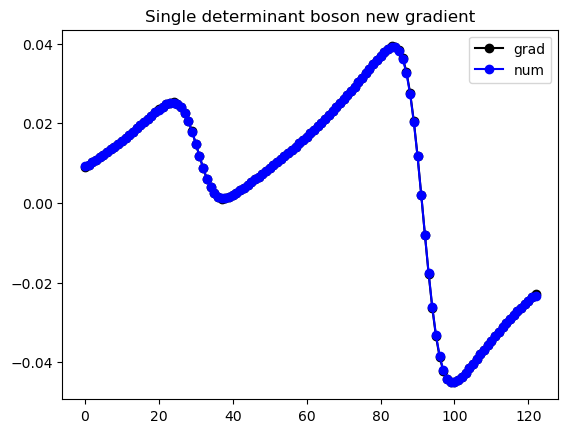

In [38]:
# Single determinant boson new gradient
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools
from accumulators import ABQMCEnergyAccumulator


nconfig = 123
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.fixed_initial_guess(mol, nconfig)
wf, to_opt = wftools.generate_boson_wf(
        mol, mf, mc=None, jastrow = None, jastrow_kws=None, slater_kws=None
    )
e=0
sign, val, _ = wf.recompute(configs)
g1, val2, _ = wf.gradient_value(e, configs.electron(e))

y1 = np.gradient(val)
y2 = g1
dx = configs.configs[1]-configs.configs[0]
dx = dx[dx!=0][0]
print(dx)
plt.plot(g1[2], '-ok', label='grad')
plt.plot(y1/dx, '-ob', label='num')
plt.legend()
plt.title('Single determinant boson new gradient')


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(320)generate_boson_wf()
    318     import pdb
    319     pdb.set_trace()
--> 320     if jastrow == None:
    321         wf, to_opt1 = generate_boson(mol, mf, mc=mc, **slater_kws)
    322         to_opt = {"wf1" + k: v for k, v in to_opt1.items()}



ipdb>  c


Number of determinants in the bosonic wavefunction= 1
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/bosonwf.py(415)gradient_value_old()
    413         pdb.set_trace()
    414         # values = \phi(R)
--> 415         if configs is not None:
    416             # calculate \phi with R'
    417             cf = configs.copy()



ipdb>  c


0.032786885245901676


Text(0.5, 1.0, 'Single determinant boson old gradient')

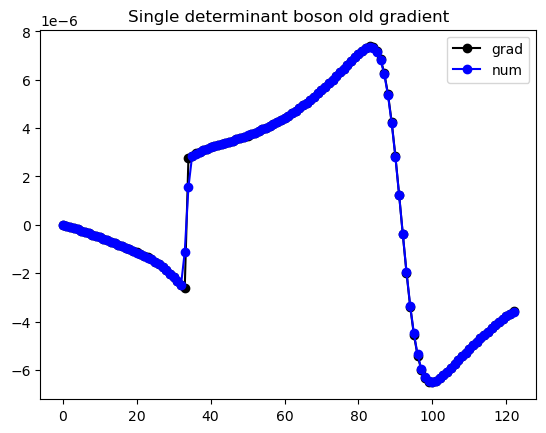

In [33]:
# Single determinant boson old gradient
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools
from accumulators import ABQMCEnergyAccumulator

nconfig = 123
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.fixed_initial_guess(mol, nconfig)
wf, to_opt = wftools.generate_boson_wf(
        mol, mf, mc=None, jastrow = None, jastrow_kws=None, slater_kws=None
    )
e=0
sign, val = wf.recompute_old(configs)
g1, val2, _ = wf.gradient_value_old(e, configs.electron(e))

y1 = np.gradient(val)
y2 = g1
dx = configs.configs[1]-configs.configs[0]
dx = dx[dx!=0][0]
print(dx)
plt.plot(g1[2], '-ok', label='grad')
plt.plot(y1/dx, '-ob', label='num')
plt.legend()
plt.title('Single determinant boson old gradient')


In [43]:
# # Single determinant boson
# nconfig = 123

# wf, configs, _ = recipes.initialize_boson_qmc_objects(
#     scf_checkfile,
# )
# configs = mc.fixed_initial_guess(mol, nconfig)
# sign, val, _ = wf.recompute(configs)
# e=0
# g1, val2, _ = wf.gradient_value(e, configs.electron(e))

# y1 = np.gradient(val)
# y2 = g1
# dx = configs.configs[1]-configs.configs[0]
# dx = dx[dx!=0][0]
# print(dx)
# plt.plot(g1[2], '-ok', label='grad')
# plt.plot(y1/dx, '-ob', label='num')
# plt.legend()
# plt.title('Single determinant boson')


In [80]:
# Multiple determinant slater
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools
from accumulators import ABQMCEnergyAccumulator

trials = 1
# for i in range(trials):
nconfig = 123
mol, mf, mcc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = 'ci.hdf5')
target_root = 0
if not hasattr(mcc.ci, "shape") or len(mcc.ci.shape) == 3:
        mcc.ci = mcc.ci[target_root]
wf, to_opt = wftools.generate_wf(
        mol, mf, mc=mcc, jastrow = None, jastrow_kws=None, slater_kws=None
    )

configs = mc.fixed_initial_guess(mol, nconfig)
# configs = mc.initial_guess(mol, nconfig, seed = 100)

e=0
sign, val = wf.recompute(configs)
# import pdb
# pdb.set_trace()
g1, val2, _ = wf.gradient_value(e, configs.electron(e))
# plt.scatter(np.exp(val), valb)

y1 = np.gradient(val)
y2 = g1
dx = configs.configs[1]-configs.configs[0]
dx = dx[dx!=0][0]
dx
plt.plot(g1[2], '-ok', label='grad')
plt.plot(y1/dx, '-ob', label='num')
plt.legend()
plt.title('Multiple determinant slater')
# plt.plot(val, '-ok', label='grad')
# plt.plot(val2, '-ob', label='num')

Number of determinants in the Fermionic wavefunction= 3
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/slater.py(193)recompute()
    191             import pdb
    192             pdb.set_trace()
--> 193             self._dets.append(
    194                 gpu.cp.asarray(np.linalg.slogdet(mo_vals))
    195             )  # Spin, (sign, val), nconf, [ndet_up, ndet_dn]



ipdb>  exit


Number of determinants in the Fermionic wavefunction= 1


Text(0.5, 1.0, 'Single determinant slater')

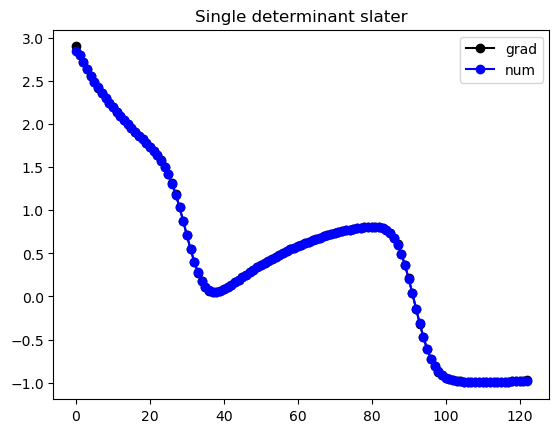

In [52]:
# Single determinant slater
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools
from accumulators import ABQMCEnergyAccumulator

trials = 1
# for i in range(trials):
nconfig = 123

mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.fixed_initial_guess(mol, nconfig)
wf, to_opt = wftools.generate_wf(
        mol, mf, mc=None, jastrow = None, jastrow_kws=None, slater_kws=None
    )
e=0
sign, val = wf.recompute(configs)
g1, val2, _ = wf.gradient_value(e, configs.electron(e))

y1 = np.gradient(val)
y2 = g1
dx = configs.configs[1]-configs.configs[0]
dx = dx[dx!=0][0]

plt.plot(g1[2], '-ok', label='grad')
plt.plot(y1/dx, '-ob', label='num')

# plt.plot(val, '-ok', label='grad')
# plt.plot(val2, '-ob', label='num')
plt.legend()
plt.title('Single determinant slater')
# plt.xlim((700,800))